# Recurrent learning

In this file the network is working with a feedback, online learning is used to make a correction when it might exagerates. 

In [ ]:
from data_loading import load_X_Y, plot_results, time_linearisation 
import numpy as np 
import matplotlib.pyplot as plt 
dpath = '../dataset/preprocessed/'

In [ ]:
from reservoirpy.datasets import to_forecasting

def normalize_data(data):
    # Normalizing data between 0 and 1 column by column
    min_vals = data.min(axis=0)
    max_vals = data.max(axis=0)
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    return normalized_data, min_vals, max_vals

data = load_X_Y(dpath + file_name)
data, min_vals, max_vals = normalize_data(data)
x,y= to_forecasting(data[3156:], forecast=7)
print(x.shape, y.shape)
y = y[:, -1].reshape(-1, 1) # chosing the data that will be used (electricity consuption)
units = 200 
alpha = 0.009838765758022786
leak_rate = 0.6079924819654108
spectral_radius = 0.8838547867045398
input_scaling = 1.0
connectivity = 0.001983076302206145
input_connectivity = 0.061394244538574685
regularization = 1e-1
seed = 42
X_train1, y_train1 = x[:1500], y[:1500]
X_test1, y_test1 = x[1500:], y[1500:]
X_test1 = np.asarray(X_test1) # chosing the data that will be used (electricity consuption)
X_test1 = X_test1.reshape(X_test1.shape[0], -1) # reshaping data that they could be used by reservoir py
# plot_train_test(X_train1, y_train1, X_test1, y_test1)


NameError: name 'load_X_Y' is not defined

In [ ]:
from reservoirpy.nodes import RLS
from reservoirpy.nodes import Reservoir 
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = RLS(alpha=alpha)


esn_online = reservoir >> readout

In [ ]:
readout = RLS(alpha=alpha)
outputs_pre = np.zeros((len(X_train1), 1))

for t, (x_t, y_t) in enumerate(zip(X_train1, y_train1)):
    outputs_pre[t] = esn_online.partial_fit(
        x_t.reshape(1, -1),
        y_t.reshape(1, -1)
    )

In [ ]:
plot_results(outputs_pre, y_train1,800)

AttributeError: module 'data_loading' has no attribute 'plot_results'

In [ ]:

esn_online = reservoir >> readout
esn_online.partial_fit(X_train1, y_train1)
pred_online = esn_online.run(X_test1)

292.85 299.5
0.0234046721301401
1.8183233242746724
(5994, 1) (5994, 1)


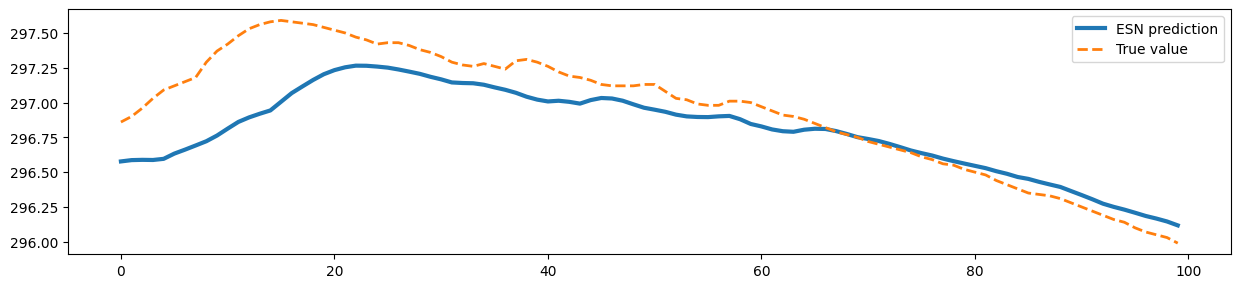

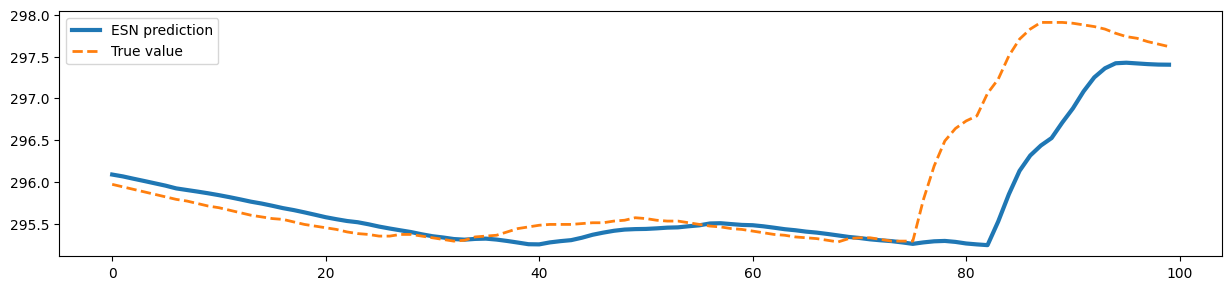

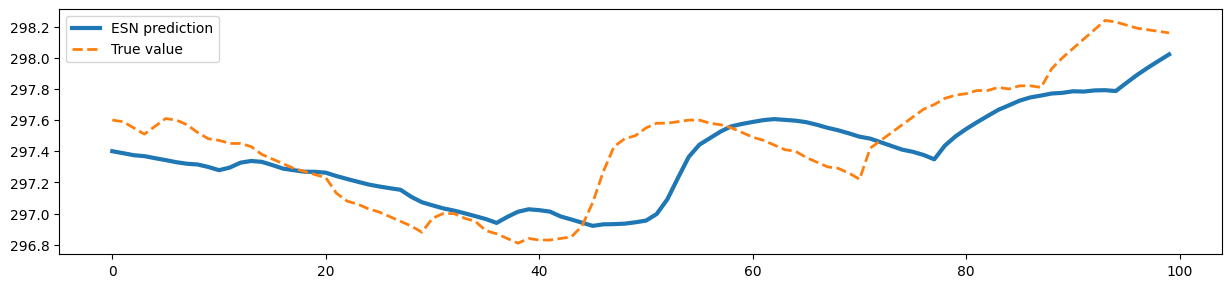

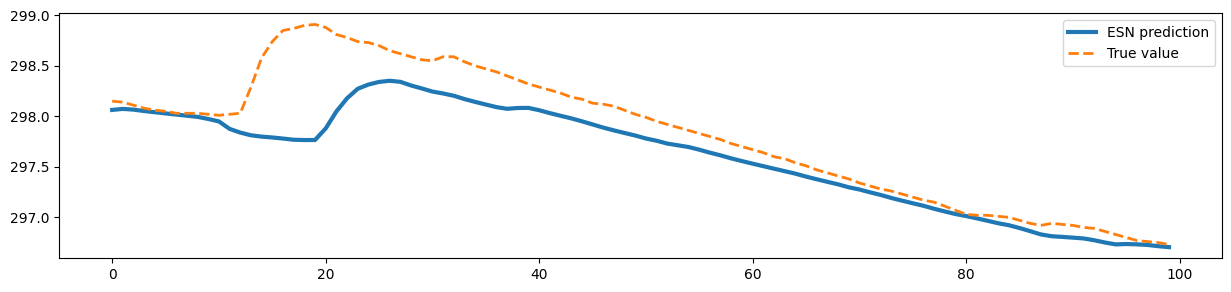

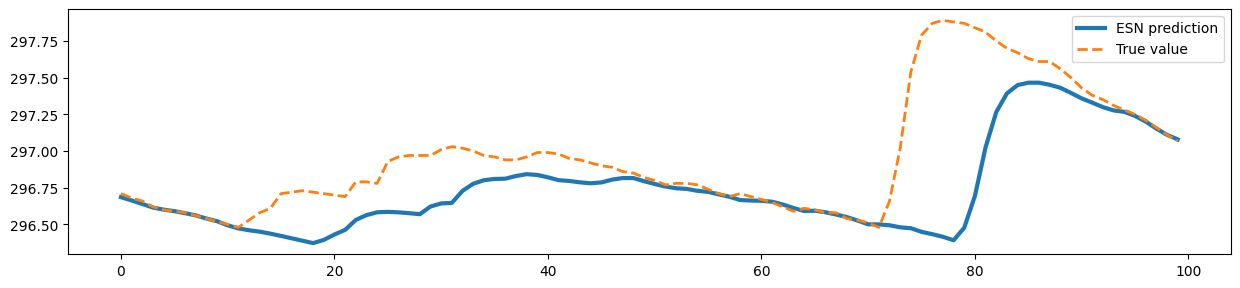

In [ ]:
def unnormalize_data(normalized_data, min_vals, max_vals):
    return normalized_data * (max_vals - min_vals) + min_vals


print( min_vals[-1], max_vals[-1])
pred_data = unnormalize_data(pred_online, min_vals[-1], max_vals[-1])
y_test_data = unnormalize_data(y_test1, min_vals[-1], max_vals[-1])
print(np.mean(y_test_data - pred_data))
print(np.max(y_test_data - pred_data))

_from = 100
_to = 200
step = _to - _from

print(pred_data.shape, y_test_data.shape)

# plot_results(pred_online[_from:],y_test1[_from:], sample=_to - _from)
for i in range(5):
    plot_results(pred_data[_from+i*step :],y_test_data[_from+i*step:], sample=step) 

With this approach, the systems is better to forecast values thanks to the feedback that allows the continue learning.  

In the group we are amazed and questionning because the reserver is able to forecast even though data is not normalized. We are wondering if this is not thanks of the readout which is marking this approaximations.  

We tried to use normalized data, but this resulted to a not working behavior then bad forecastings. We are willing to work on this for the next days to find why this was not woeking as expected.  

In [ ]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result of the loss function.
# You can add any additional metrics or information with other keys in the dict. See hyperopt documentation for more informations.
from reservoirpy.observables import nrmse, rsquare
from reservoirpy.nodes import Ridge

In [ ]:
import json

exp_directory = "exps/"
exp_config_directory = "configs/"

exp_name = "hyperopt-input"
exp_version = 3 # calculate the version number based on existing files in the directory 

hyperopt_config = {
    "exp": exp_name+str(exp_version),    # the experimentation name
    "hp_max_evals": 200,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 200],             # the number of neurons is fixed to 500
        "sr": ["choice", 0.8838547867045398],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-1, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["loguniform", 5e-1, 1], # the input scaling is fixed
        "alpha": ["loguniform", 1e-4, 1e-1],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [ ]:

def objective(dataset, config, *, input_scaling, N, sr, lr, alpha, seed):
    # This step may vary depending on what you put inside 'dataset'
    x_train, x_test, y_train, y_test = dataset
    
    # You can access anything you put in the config file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances to be sure there is no bias in the results due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N, 
            sr=sr, 
            lr=lr, 
            input_scaling=input_scaling, 
            seed=variable_seed
        )

        readout = RLS(alpha=alpha)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [ ]:
train_len = 1000
forecast = 7

X_train = x[:train_len]
Y_train = x[forecast : train_len + forecast]

X_test = x[train_len : -forecast]
Y_test = x[train_len + forecast:]

dataset = (X_train, X_test, Y_train, Y_test)

In [ ]:
from reservoirpy.datasets import to_forecasting

X_train, X_test, Y_train, Y_test = to_forecasting(x, forecast=forecast, test_size=train_len-forecast)

In [ ]:
from reservoirpy.hyper import parallel_research
best = parallel_research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [02:48<00:00,  1.19trial/s, best loss=0.0259]


In [ ]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "alpha", "input_scaling"), metric="r2")

KeyError: 'input_scaling'

In [ ]:
hyperopt_config = {
    "exp": "hyperopt-input-scaling-multi-1",    # the experimentation name
    "hp_max_evals": 200,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 200],             # the number of neurons is fixed to 500
        "sr": ["choice", 0.8838547867045398],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["choice", 0.4981590552238297],    # idem with the leaking rate, from 1e-3 to 1
        # "input_scaling": ["loguniform", [5e-1, 5e-1, 5e-1],[ 1,1,1]], # the input scaling is fixed
        "alpha": ["choice", 0.009838765758022786],        # and so is the regularization parameter.
        "input_connectivity": ["choice", 0.061394244538574685], # exploring input connectivity
        # "connectivity": ["loguniform", 1e-3, 1], # exploring reservoir connectivity
        "seed": ["choice", 1234],          # an other random seed for the ESN initialization
        "input_scaling_1":  ["loguniform", 1e-5, 1e0], 
        "input_scaling_2":  ["loguniform", 1e-5, 1e0], 
        "input_scaling_3":  ["loguniform", 1e-5, 1e0], 
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [ ]:
from reservoirpy.mat_gen import bernoulli
# N = 200
# Win_default = bernoulli(N, X_train.shape[1], connectivity=input_connectivity )
# # print(Win_default)
# Input_Scaling = [1,0.2,0.3]
# # print(Win_default * Input_Scaling )


# # self.Win = self.Win(
# #                 self.units,
# #                 self.input_dim,
# #                 input_scaling=self.input_scaling,
# #                 connectivity=self.input_connectivity,
# #                 dtype=self.dtype,
# #                 seed=Win_rng,
# #             )

def objective(dataset, config, *, N, sr, lr, alpha, input_connectivity, seed, input_scaling_1, input_scaling_2, input_scaling_3):
    # This step may vary depending on what you put inside 'dataset'
    x_train, x_test, y_train, y_test = dataset
    
    # You can access anything you put in the config file from the 'config' parameter.
    instances = config["instances_per_trial"]
    

    Win_default = bernoulli(N, x_train.shape[1], connectivity=input_connectivity )
    Input_Scaling = [input_scaling_1, input_scaling_2, input_scaling_3]

    # The seed should be changed across the instances to be sure there is no bias in the results due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N, 
            sr=sr, 
            lr=lr, 
            # input_scaling=Input_Scaling,
            seed=variable_seed,
            input_connectivity=input_connectivity,
            rc_connectivity=connectivity,
            Win=Win_default * Input_Scaling
        )

        readout = RLS(alpha=alpha)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [ ]:
from reservoirpy.hyper import parallel_research
best = parallel_research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [02:39<00:00,  1.25trial/s, best loss=0.0223]


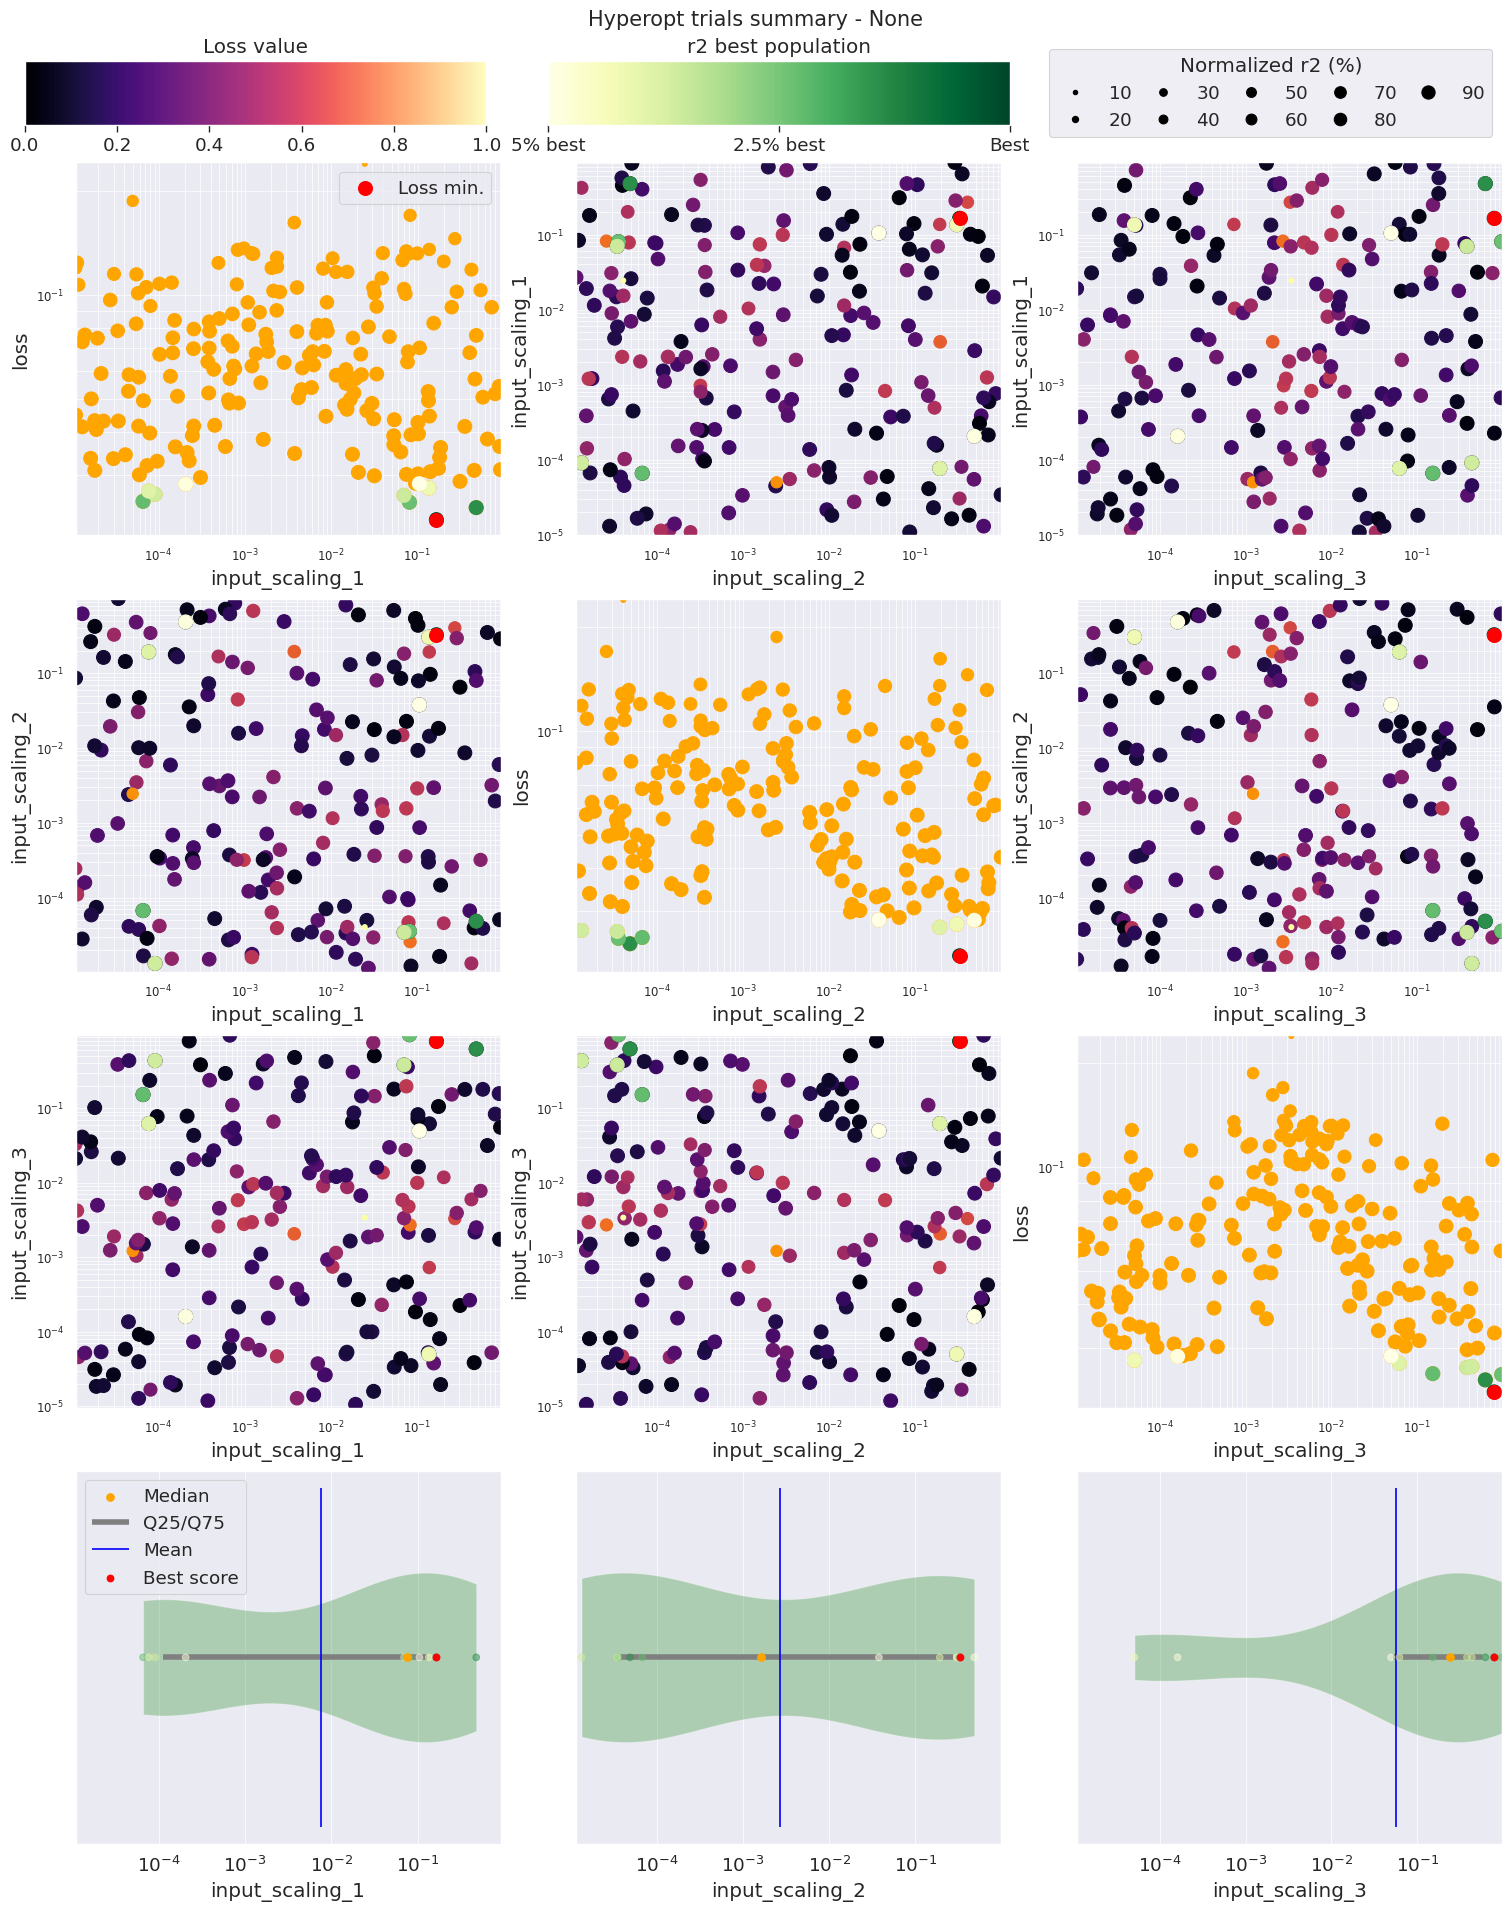

In [ ]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("input_scaling_1", "input_scaling_2", "input_scaling_4"), metric="r2")